In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import os

twitter_file = "twitter_labeled (1).csv"
youtube_file = "youtube_cleaned_balanced.csv"
reddit_file  = "reddit_labeled.csv"

dfs = {}
for name, path in [("Twitter", twitter_file), ("YouTube", youtube_file), ("Reddit", reddit_file)]:
    if os.path.exists(path):
        dfs[name] = pd.read_csv(path)
    else:
        print(f"Notice: {name} file not found → {path}")

TEXT_CANDIDATES = [
    "Text","text","Comment","comment","Clean Text","clean_text",
    "Comment_Text","comment_text","body","Body","title","Title"
]

def _canon(s: str) -> str:
    return ''.join(ch for ch in s.lower().strip() if ch.isalnum())

def _find_col(df, names):
    want = {_canon(n) for n in names}
    for c in df.columns:
        if _canon(c) in want:
            return c
    return None

def normalize_df(df: pd.DataFrame) -> pd.DataFrame:
    # text
    text_col = _find_col(df, TEXT_CANDIDATES)
    if not text_col:
        raise ValueError(f"No text-like column found. Available: {list(df.columns)}")
    df = df.rename(columns={text_col: "text"})

    # label
    label_col = _find_col(df, ["Label","label"])
    if label_col and label_col != "label":
        df = df.rename(columns={label_col: "label"})
    elif "label" not in df.columns:
        df["label"] = pd.NA

    # engagement (accept typo too)
    eng_col = _find_col(df, ["Engagement","engagement","Engment","engment"])
    if eng_col and eng_col != "engagement":
        df = df.rename(columns={eng_col: "engagement"})
    elif "engagement" not in df.columns:
        df["engagement"] = pd.NA

    # matched keywords (optional)
    mk_col = _find_col(df, ["Matched Keywords","matched_keywords"])
    if mk_col and mk_col != "matched_keywords":
        df = df.rename(columns={mk_col: "matched_keywords"})
    elif "matched_keywords" not in df.columns:
        df["matched_keywords"] = pd.NA

    df["text"] = df["text"].astype(str)
    return df[["text","label","engagement","matched_keywords"]]

# apply
for k in list(dfs.keys()):
    dfs[k] = normalize_df(dfs[k])

# quick sanity prints
for k, v in dfs.items():
    print(f"\n== {k} == shape: {v.shape}")
    print(v.head(3))



== Twitter == shape: (90, 4)
                                                text  label  engagement  \
0  RT @MikeCrispi: LIVE on the ground outside the...      0         130   
1  RT @AdamMoczar: ⚡🇺🇲 Charlie Kirk: “Islam is NO...      0        1088   
2  RT @aldamu_jo: Israeli police clashed with ult...      0        1219   

  matched_keywords  
0              NaN  
1          Muslims  
2             Jews  

== YouTube == shape: (160, 4)
                                                text  label  engagement  \
0  It's weird you're seeing that MAGA will critic...      0        1495   
1  "Were here to save hostages!" they say bombing...      0           0   
2  😂😂 hunting down  investigating people in a cha...      0           0   

  matched_keywords  
0      hate speech  
1              NaN  
2              NaN  

== Reddit == shape: (136, 4)
                                                text      label  engagement  \
0  attorney general pam bondi there's free speech...  non-to

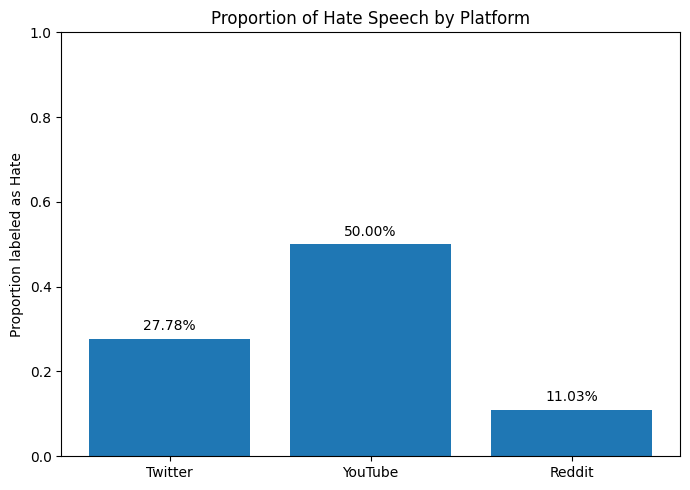

In [ ]:

import numpy as np


platforms, hate_props = [], []

for p, df in dfs.items():
    # Make a numeric copy of label
    lbl = (
        df['label']
        .astype(str).str.strip().str.lower()
        .map({
            '1': 1, '0': 0,
            'toxic': 1, 'non-toxic': 0,
            'hate': 1, 'not hate': 0,
            'offensive': 1, 'neutral': 0
        })
    )
    # If some are already numeric, recover them:
    lbl = lbl.fillna(pd.to_numeric(df['label'], errors='coerce'))

    # Use only rows that have a valid numeric label
    mask = lbl.notna()
    if mask.sum() == 0:
        continue

    total = mask.sum()
    hate = lbl[mask].sum()
    platforms.append(p)
    hate_props.append(float(hate) / float(total))

# Plot
plt.figure(figsize=(7,5))
plt.bar(platforms, hate_props)
plt.ylabel("Proportion labeled as Hate")
plt.title("Proportion of Hate Speech by Platform")
plt.ylim(0, 1)

for i, v in enumerate(hate_props):
    y = min(v + 0.02, 0.98)  # avoid printing outside the frame
    plt.text(i, y, f"{v:.2%}", ha='center')

plt.tight_layout()
plt.show()


/tmp/ipython-input-3584015663.py:49: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(values, labels=labels, showfliers=False)


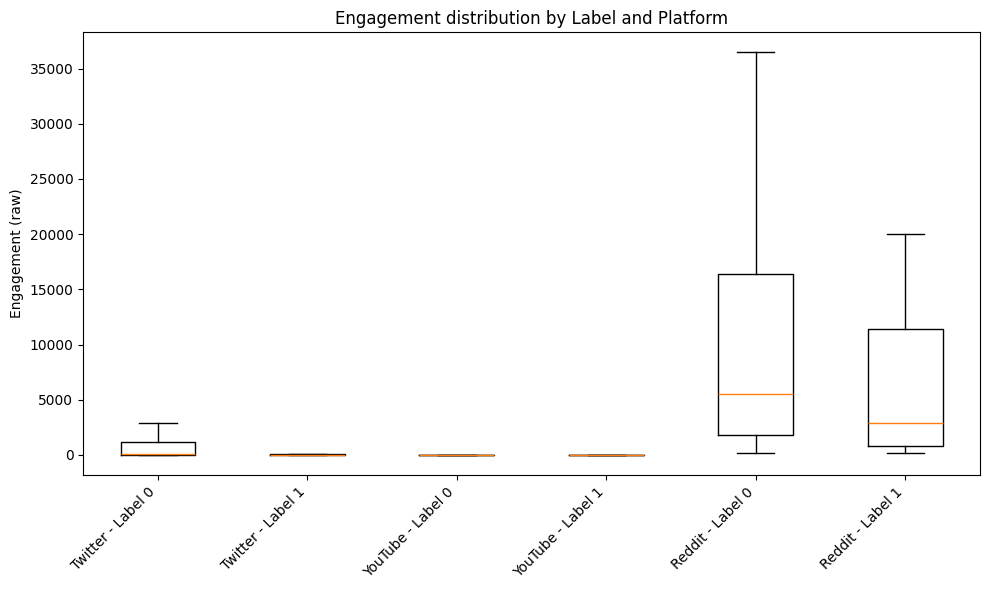

In [ ]:

def to_binary_label(x):
    s = str(x).strip().lower()
    mapping = {
        '1': 1, '0': 0,
        'toxic': 1, 'non-toxic': 0,
        'hate': 1, 'not hate': 0,
        'offensive': 1, 'neutral': 0
    }
    # try mapping; if not found, try numeric; else NaN
    if s in mapping:
        return mapping[s]
    try:
        return int(float(s))
    except:
        return np.nan

plt.figure(figsize=(10,6))

labels = []
values = []
platform_labels = []

for p, df in dfs.items():
    # Make sure the two columns exist
    if 'label' not in df.columns or 'engagement' not in df.columns:
        continue

    # Coerce to usable types
    lbl = df['label'].apply(to_binary_label)
    eng = pd.to_numeric(df['engagement'], errors='coerce')

    # Valid rows = both label and engagement present
    valid = lbl.notna() & eng.notna()
    if valid.sum() == 0:
        continue

    # Plot 0 and 1 separately
    for lab in (0, 1):
        subset = eng[valid & (lbl == lab)]
        if subset.empty:
            continue
        labels.append(f"{p} - Label {lab}")
        values.append(subset.values)  # numpy array is fine
        platform_labels.append(p)

if not values:
    print("No data available to plot (after cleaning).")
else:
    plt.boxplot(values, labels=labels, showfliers=False)
    plt.xticks(rotation=45, ha='right')
    plt.ylabel("Engagement (raw)")
    plt.title("Engagement distribution by Label and Platform")
    plt.tight_layout()
    plt.show()

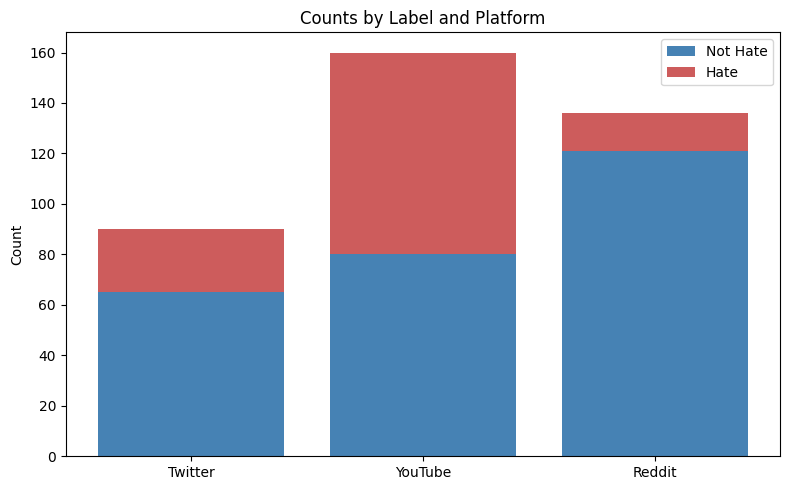

In [ ]:
plt.figure(figsize=(8,5))

counts_hate = []
counts_not = []
labels = list(dfs.keys())

for p in labels:
    df = dfs[p]
    # Convert labels to 0/1
    lbl = df['label'].apply(to_binary_label)
    lbl = lbl.dropna()

    hate = (lbl == 1).sum()
    not_hate = (lbl == 0).sum()

    counts_hate.append(hate)
    counts_not.append(not_hate)

# Stacked bar plot
plt.bar(labels, counts_not, label='Not Hate', color='steelblue')
plt.bar(labels, counts_hate, bottom=counts_not, label='Hate', color='indianred')

plt.ylabel("Count")
plt.title("Counts by Label and Platform")
plt.legend()
plt.tight_layout()
plt.show()

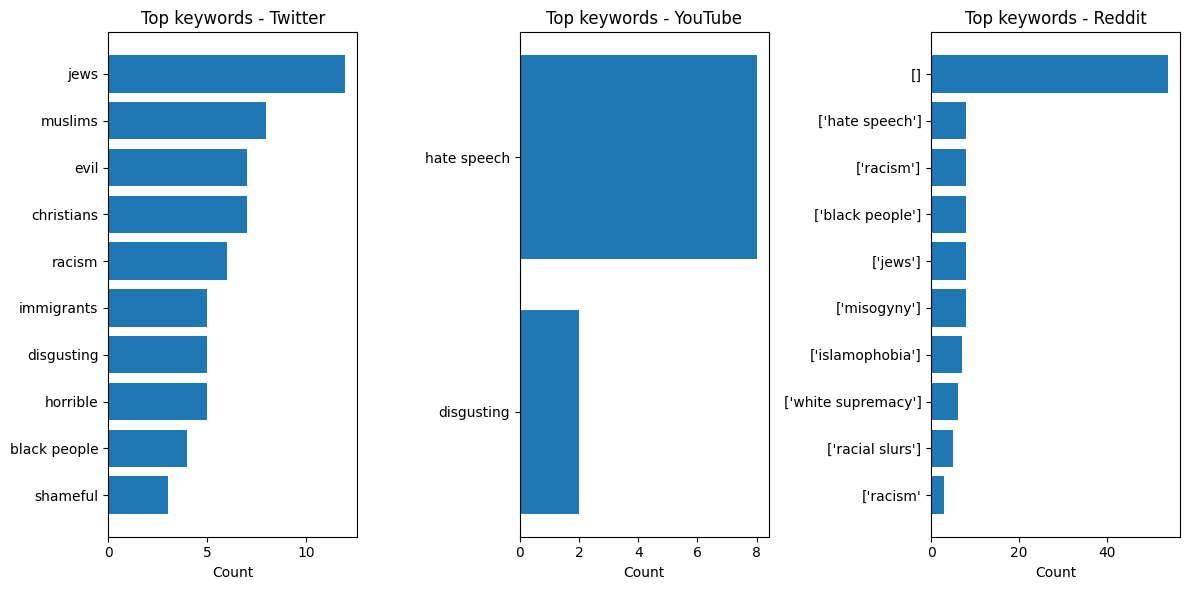

In [ ]:
def extract_keywords_field(s):
    if pd.isna(s):
        return []
    # نفترض إنها سلسلة من كلمات مفصولة بفواصل
    if isinstance(s, str):
        # نظم: "kw1, kw2" -> قائمة
        return [k.strip().lower() for k in s.split(',') if k.strip()]
    return []

plt.figure(figsize=(12,6))
for i, (p, df) in enumerate(dfs.items()):
    all_kws = []
    for s in df['matched_keywords'].dropna().astype(str):
        all_kws += extract_keywords_field(s)
    counter = Counter(all_kws)
    most = counter.most_common(10)
    if not most:
        continue
    kws, counts = zip(*most)
    plt.subplot(1, len(dfs), i+1)
    plt.barh(kws[::-1], counts[::-1])
    plt.title(f"Top keywords - {p}")
    plt.xlabel("Count")
plt.tight_layout()
plt.show()

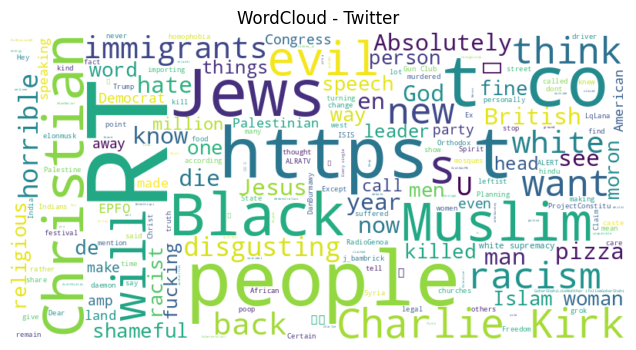

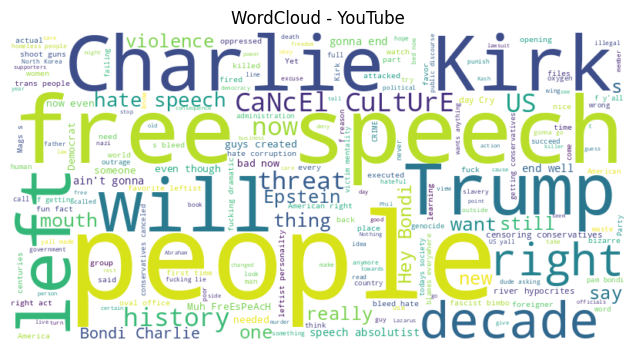

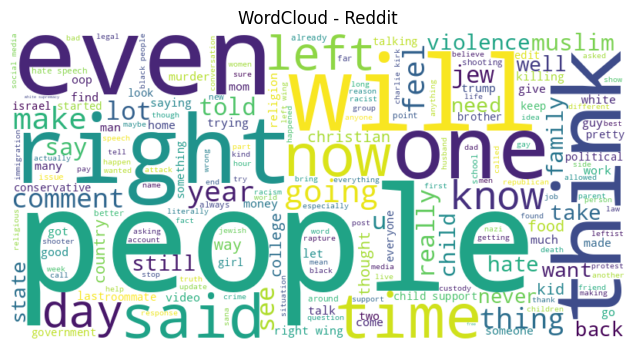

In [ ]:
# pip install wordcloud
from wordcloud import WordCloud

for p, df in dfs.items():
    text_blob = " ".join(df['text'].astype(str).tolist())
    if len(text_blob.strip()) == 0:
        continue
    wc = WordCloud(width=800, height=400, background_color='white').generate(text_blob)
    plt.figure(figsize=(10,4))
    plt.imshow(wc, interpolation='bilinear')
    plt.axis('off')
    plt.title(f"WordCloud - {p}")
    plt.show()

    print("\n")
